In [1]:
import matplotlib.pyplot as plt
import matplotlib
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml
import pathlib

import pickle
import pathlib

import mlflow

matplotlib.rcParams.update({'font.size': 14})

In [2]:
from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 25
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/lbmpc_semimarkov")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/data/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(path_mlruns)

# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    # list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    # assert len(list_glob_config) == 1, "More than one config file in the directory."

    # name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    # assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    # path_run_config_yaml = list_glob_config[0]

    dict_config_temp = mlflow.get_run(name_id).data.params
    nested_dict_config[name_id] = dict_config_temp
    list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))

    # with open(path_run_config_yaml, "r") as file:
    # Get the config file as a dictionary
    # dict_config_temp = yaml.safe_load(file)
    # Add the config file to the nested dictionary
    # nested_dict_config[name_id] = dict_config_temp
    # Flatten the config file for easier check
    # list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    # del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name",
                               "_id"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

Number of runs: 40 

XP id: 25 

Set of non unique keys: {'alg_n_semimarkov_dt', '_id', 'seed'} 

First config file: e58d331d91674dbe8de11f4f78974268 

path_sampling_noise: '0.01'
name: 2023_12_08_pendulum_sm_action_0.5_ep_length_300_num_iters_100
num_eval_trials: '5'
eigmpc_nsamps: '25'
env_environment_parameters_dict_pde_config_ep_length: '300'
env_mpc_n_elites: '1'
alg_sample_all_states: 'False'
env_tf_precision: '64'
test_mpc_n_elites: '1'
alg_learn_reward: 'False'
alg_open_loop_mpc: 'False'
normalize_env: 'True'
test_mpc_actions_per_plan: '1'
mpc_planning_horizon: '2'
n_paths: '15'
test_mpc_beta: '1'
env_eigmpc_actions_per_plan: '1'
sample_init_initially: 'True'
env_eigmpc_gamma: '1.25'
env_eigmpc_planning_horizon: '2'
alg_uncertainty_sampling: 'False'
test_mpc_num_iters: '1'
alg_num_fs: '15'
path_sampling_fraction: '0.8'
test_mpc_num_fs: '15'
alg_kg_policy: 'False'
fit_hypers: 'False'
env_environment_parameters_dict_pde_config_dt: '0.05'
seed: '0'
env_gp_alpha: '[0.03, 13.94]'
te

In [3]:
(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 # .groupby(["seed", "alg_n_semimarkov_dt"])
 # .loc[:, ["alg_num_iters", "crop_to_domain", "project_to_domain", "alg_n_semimarkov_dt", "seed", "name"]]
 .loc[:, ["alg_num_iters", "alg_n_semimarkov_dt", "seed", "name"]]
 .nunique()

 )

alg_num_iters           1
alg_n_semimarkov_dt     4
seed                   10
name                    1
dtype: int64

In [4]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }
# Get the first dict_config
dict_config_ref = nested_dict_config[list_id_hash[0]]
# Length of the exploration trajectory
length_trajectory = int(dict_config_ref["num_iters"]) + 1
n_eval_trajectory = int(dict_config_ref["num_eval_trials"])
# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

        list_array = []
        eval_frequency = int(nested_dict_config[name_id]["eval_frequency"])

        list_excluded_columns_reshape = ["Acquisition Function Value",
                                         "mean_difference_state_boostrap",
                                         "n_corresponding_dt"]

        dict_temp = \
            {name_column: pd.Series(
                dict_data[name_column],
                index=([0, ] + list(np.arange(1, length_trajectory, step=eval_frequency, dtype=int))))

                for name_column in list_name_columns_learning
                if name_column not in list_excluded_columns_reshape}
        # Add the excluded columns without reshaping
        dict_temp.update(
            {name_column: pd.Series(dict_data[name_column], index=np.arange(length_trajectory - 1))
             for name_column in list_excluded_columns_reshape})
        df_learning_data_temp = (
            pd.DataFrame(dict_temp)
            .explode("Eval Returns")
            .reset_index(names=["iteration"])
            .rename(columns=dict_columns_learning_renaming_map)
        )

    list_df_learning_data.append(df_learning_data_temp)

In [5]:
# Get the list of the delay mode
list_action_delay_mode = [int(nested_dict_config[name_id]["alg_n_semimarkov_dt"])
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [6]:
df_learning_data.describe()

,iteration,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
count,12160.000000,10200.000000,1.020000e+04,10200.000000,10200.000000,10200.000000,10200.000000,12160.000000,1.216000e+04,12160.000000
mean,49.177632,50.980392,1.114573e-01,0.221028,0.094783,-1.853489,-1.873257,1.729655,1.043139e-01,2.977056
std,29.231707,29.407650,1.421200e-01,0.211261,0.121429,0.014566,0.039926,1.166045,5.898749e-01,2.301028
min,0.000000,1.000000,3.146318e-08,0.004106,0.000006,-1.927261,-2.085273,0.212358,0.000000e+00,1.000000
25%,23.750000,25.000000,2.512687e-02,0.024846,0.030673,-1.863837,-1.889880,0.856635,5.551115e-17,1.000000
50%,49.000000,51.000000,5.808913e-02,0.172231,0.059226,-1.850332,-1.857277,1.307191,4.074390e-04,2.000000
75%,75.000000,77.000000,1.498670e-01,0.370526,0.119101,-1.839941,-1.845901,2.270525,5.050998e-03,4.000000
max,99.000000,100.000000,1.096473e+00,1.111946,0.917294,-1.838171,-1.838055,6.463684,7.571392e+00,8.000000


In [7]:
n_eval_trajectory = int(nested_dict_config[list_id_hash[0]]["num_eval_trials"])

(df_learning_data
 .infer_objects()
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"]))

iteration  eval_returns  \
run_id                           action_delay_mode                            
e58d331d91674dbe8de11f4f78974268 4                          0  -1798.693456   
                                 4                          0  -2129.427168   
                                 4                          0  -1900.763540   
                                 4                          0  -2166.377513   
                                 4                          0  -1896.379359   
...                                                       ...           ...   
4c2e038972af45a680c6407643dbc302 2                         99   -422.887190   
                                 2                         99   -408.157850   
                                 2                         99   -704.280785   
                                 2                         99   -421.673628   
                                 2                         99   -731.716079   

                                                    eval_ndata  \
run_id                           action_delay_mode               
e58d331d91674dbe8de11f4f78974268 4                         1.0   
                                 4                         1.0   
                                 4                         1.0   
                                 4                         1.0   
                                 4                         1.0   
...                                                        ...   
4c2e038972af45a680c6407643dbc302 2                       100.0   
                                 2                       100.0   
                                 2                       100.0   
                                 2                       100.0   
                                 2                       100.0   

                                                    model_mse_current_real_mpc  \
run_id                           action_delay_mode                               
e58d331d91674dbe8de11f4f78974268 4                                    0.003805   
                                 4                                    0.003805   
                                 4                                    0.003805   
                                 4                                    0.003805   
                                 4                                    0.003805   
...                                                                        ...   
4c2e038972af45a680c6407643dbc302 2                                    0.181463   
                                 2                                    0.181463   
                                 2                                    0.181463   
                                 2                                    0.181463   
                                 2                                    0.181463   

                                                    model_mse_random_test_set  \
run_id                           action_delay_mode                              
e58d331d91674dbe8de11f4f78974268 4                                   0.004106   
                                 4                                   0.004106   
                                 4                                   0.004106   
                                 4                                   0.004106   
                                 4                                   0.004106   
...                                                                       ...   
4c2e038972af45a680c6407643dbc302 2                                   0.398301   
                                 2                                   0.398301   
                                 2                                   0.398301   
                                 2                                   0.398301   
                                 2                                   0.398301   

                                            

##### Plotting metrics from pickle data

================== eig ==================


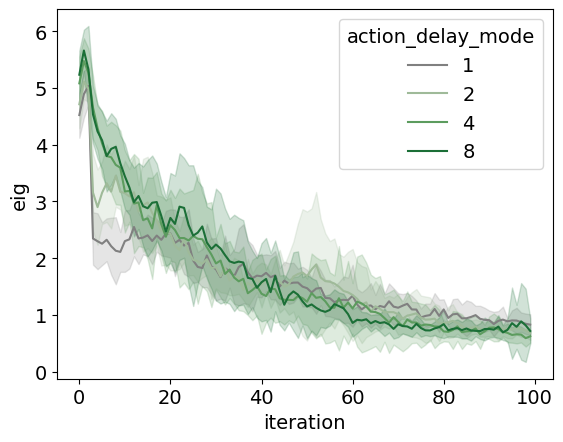

================== eval_returns ==================


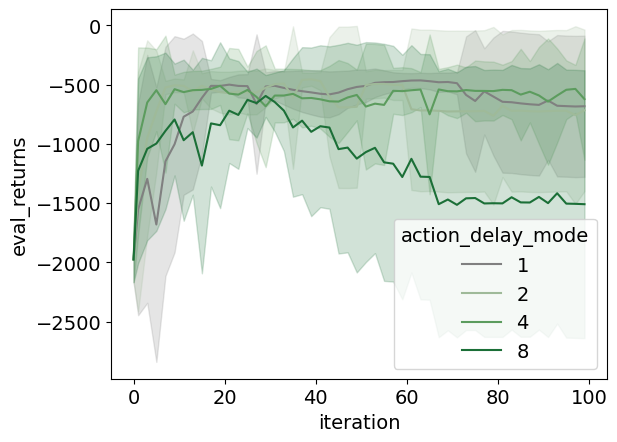

================== mean_difference_state_bootstrap ==================


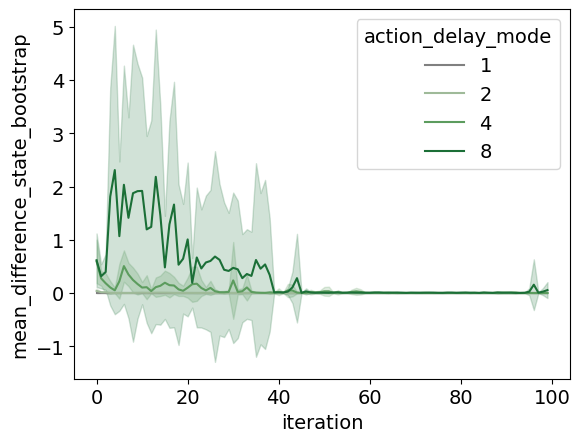

================== n_corresponding_dt ==================


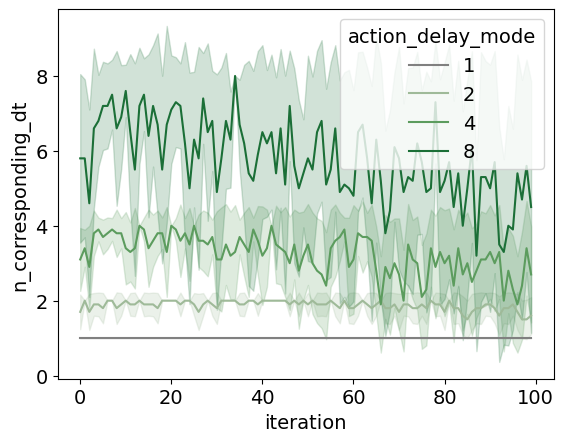

================== model_mse_current_real_mpc ==================


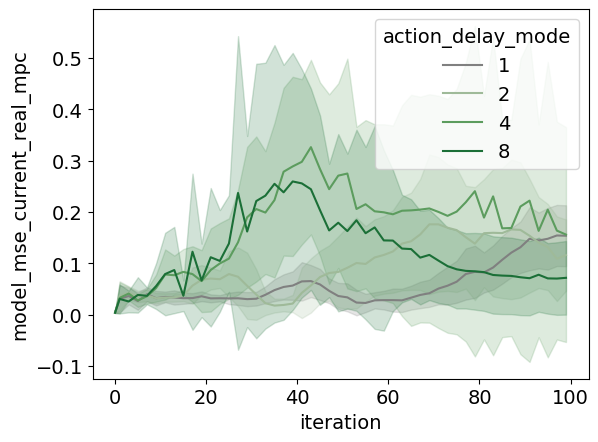

================== model_mse_random_test_set ==================


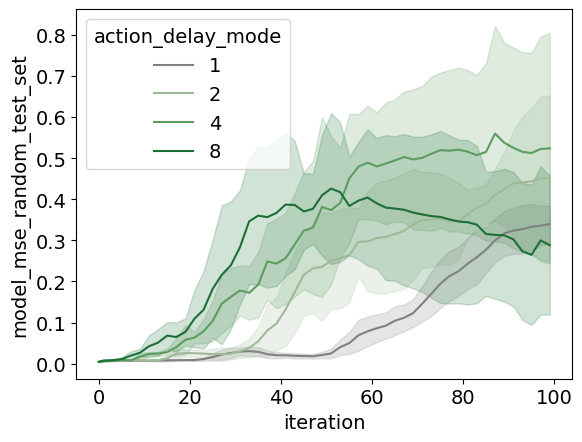

================== model_mse_gt_mpc ==================


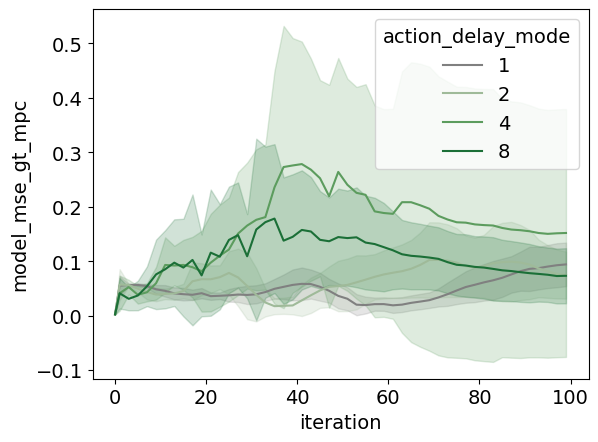

================== model_likelihood_random_test_set ==================


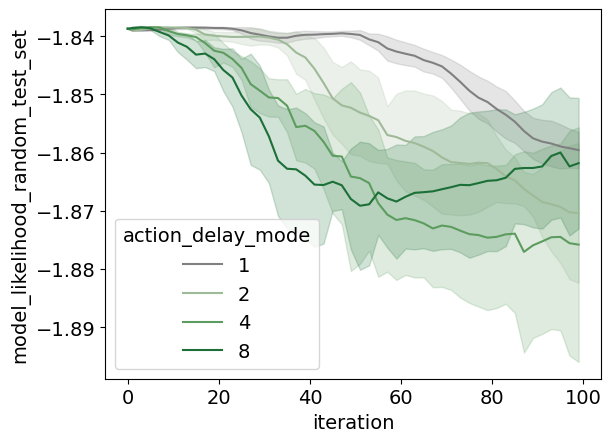

================== model_likelihood_gt_mpc ==================


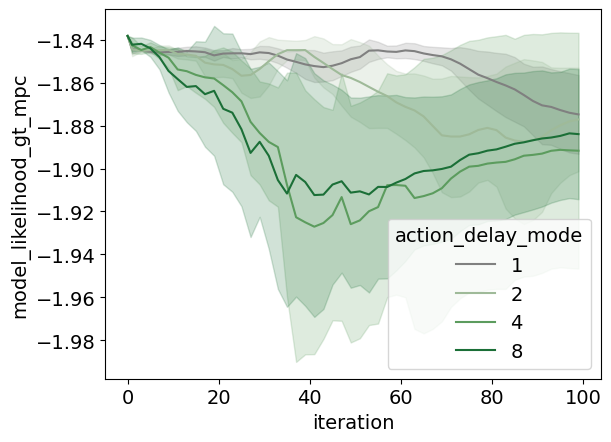

================== eval_ndata ==================


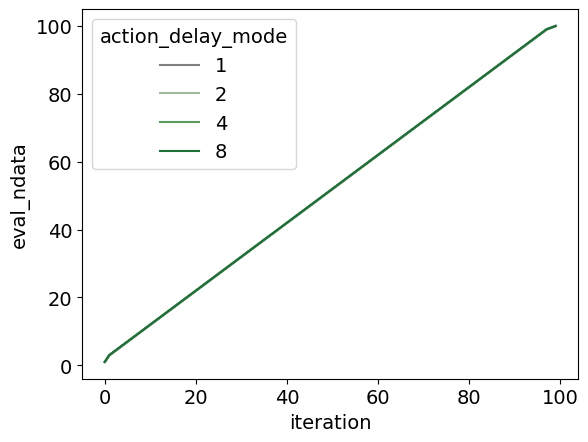

In [8]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Greens", len(set(list_action_delay_mode)) - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.8
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["Grey"] + sns_other_palette
# list_color_palette = ["black"] + sns.color_palette("Greens", len(list_action_delay_mode) - 1).as_hex()
df_plot = df_learning_data.reset_index()

list_columns_plot = ["eig", "eval_returns", "mean_difference_state_bootstrap", "n_corresponding_dt",
                     "model_mse_current_real_mpc", "model_mse_random_test_set",
                     "model_mse_gt_mpc", "model_likelihood_random_test_set", "model_likelihood_gt_mpc", "eval_ndata"]

plt.close()
for name_column in list_columns_plot:
    print(f"================== {name_column} ==================")
    g = sns.lineplot(data=df_plot,
                     x="iteration",
                     y=name_column,
                     hue="action_delay_mode",
                     errorbar="sd",
                     legend="full",
                     palette=list_color_palette)
    plt.show()
    # Save the   figure
    # g.figure.savefig(f"/home/hosseinkhan/Downloads/temp_imgs/{name_column}.png")
    # plt.close()

### Objective function evolution

[Text(0.5, 0, 'Sampling iteration   $n$'),
 Text(0, 0.5, 'Evaluation of Objective Function   $J^\\pi$'),
 Text(0.5, 1.0, 'Evolution of   $J^\\pi$   over the sampling iterations  $n$')]

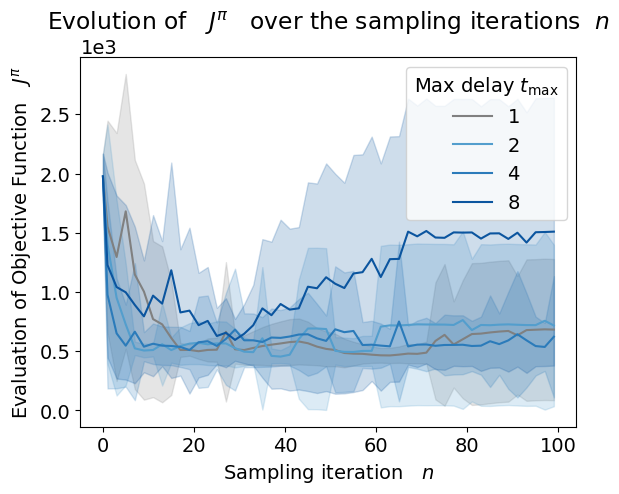

In [9]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Blues")[-(len(set(list_action_delay_mode)) - 1):]

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_barl_semimarkov_post_review/images"
folder_name = "objective_function_evolution"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)



# Increase darkness of all colors in palette
list_color_palette = ["Grey"] + sns_other_palette
df_plot = (df_learning_data
           .reset_index()
           .assign(eval_returns=lambda df: -df["eval_returns"].astype(float)))

g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y="eval_returns",
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
g.set(xlabel="Sampling iteration   $n$",
      ylabel="Evaluation of Objective Function   $J^\pi$",
      title="Evolution of   $J^\pi$   over the sampling iterations  $n$")
g.axes.get_legend().set_title("Max delay $t_{\\text{max}}$")
g.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.show()
# Save the figure
g.figure.savefig(f"{path_save_fig}/pendulum.png")
plt.close()

[Text(0.5, 0, 'Sampling iteration   $n$'),
 Text(0, 0.5, 'Interdecision time $\\tau_n$'),
 Text(0.5, 1.0, 'Evolution of   $\\tau_n$   over the sampling iterations  $n$')]

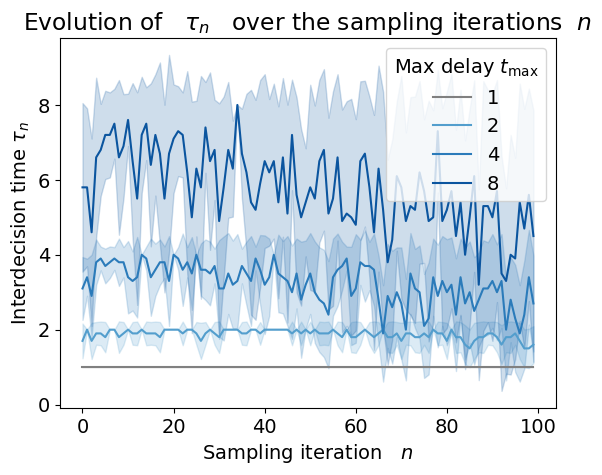

In [10]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Blues")[-(len(set(list_action_delay_mode)) - 1):]

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_barl_semimarkov_post_review/images"
folder_name = "interdecision_time_evolution"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

# Increase darkness of all colors in palette
list_color_palette = ["Grey"] + sns_other_palette
df_plot = (df_learning_data
           .reset_index()
           .assign(eval_returns=lambda df: -df["eval_returns"].astype(float)))

g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y="n_corresponding_dt",
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
g.set(xlabel="Sampling iteration   $n$",
      ylabel="Interdecision time $\\tau_n$",
      title="Evolution of   $\\tau_n$   over the sampling iterations  $n$")
g.axes.get_legend().set_title("Max delay $t_{\\text{max}}$")

plt.show()
# Save the figure
g.figure.savefig(f"{path_save_fig}/pendulum.png")
# plt.close()

[Text(0.5, 0, 'Sampling iteration   $n$'),
 Text(0, 0.5, 'Expected Information Gain   $EIG_n$'),
 Text(0.5, 1.0, 'Evolution of   $EIG_n$   over the sampling iterations  $n$')]

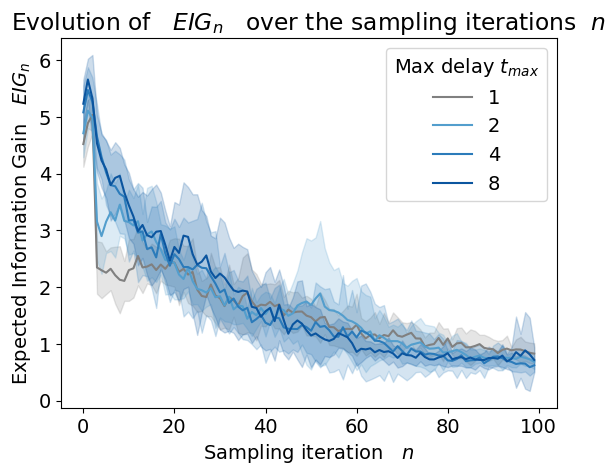

In [11]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Blues")[-(len(set(list_action_delay_mode)) - 1):]

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_barl_semimarkov_post_review/images"
folder_name = "eig_evolution"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

# Increase darkness of all colors in palette
list_color_palette = ["Grey"] + sns_other_palette
df_plot = (df_learning_data
           .reset_index()
           .assign(eval_returns=lambda df: -df["eval_returns"].astype(float)))

g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y="eig",
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
g.set(xlabel="Sampling iteration   $n$",
      ylabel="Expected Information Gain   $EIG_n$",
      title="Evolution of   $EIG_n$   over the sampling iterations  $n$")
g.axes.get_legend().set_title("Max delay $t_{max}$")

plt.show()
# Save the figure
g.figure.savefig(f"{path_save_fig}/pendulum.png")
plt.close()

In [12]:
import ast

dim_x = len(ast.literal_eval(nested_dict_config[list_id_hash[0]]["env_gp_alpha"]))
dim_u = len(ast.literal_eval(nested_dict_config[list_id_hash[0]]["env_gp_ls"])[0]) - dim_x

list_df_trajectory_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

    df_trajectory_data_temp = (pd.concat(
        [pd.DataFrame(np.array(dict_data["x"])[:, :dim_x]), pd.DataFrame(np.array(dict_data["x"])[:, dim_x:])],
        axis="columns",
        keys=["state", "action"],
        names=["component", "i"]).assign(n_corresponding_dt=[0] + list(np.array(dict_data["n_corresponding_dt"])),
                                         iteration_exploration=[0] + list(
                                             np.array(dict_data["n_corresponding_dt"]).cumsum()),
                                         seed=nested_dict_config[name_id]["seed"])
                               .rename_axis("iteration", axis="index")

                               )

    list_df_trajectory_data.append(df_trajectory_data_temp)

In [13]:
df_trajectory_data = (pd.concat(list_df_trajectory_data, keys=list_keys_tuple_id_action_delay_mode,
                                names=["run_id", "action_delay_mode"])
                      .infer_objects()
                      .convert_dtypes()
                      .astype({"seed": "category", "n_corresponding_dt": "category"})
                      )

In [14]:
df_trajectory_data

component                                                        state  \
i                                                                    0   
run_id                           action_delay_mode iteration             
e58d331d91674dbe8de11f4f78974268 4                 0          0.000497   
                                                   1          0.002178   
                                                   2          0.003188   
                                                   3           0.00619   
                                                   4          0.012281   
...                                                                ...   
4c2e038972af45a680c6407643dbc302 2                 96        -0.040703   
                                                   97        -0.041511   
                                                   98        -0.041509   
                                                   99        -0.041177   
                                                   100       -0.040512   

component                                                               \
i                                                                    1   
run_id                           action_delay_mode iteration             
e58d331d91674dbe8de11f4f78974268 4                 0         -0.017346   
                                                   1          0.053502   
                                                   2          0.129394   
                                                   3          0.294042   
                                                   4          0.568314   
...                                                                ...   
4c2e038972af45a680c6407643dbc302 2                 96        -0.257428   
                                                   97         -0.08035   
                                                   98         0.000673   
                                                   99         0.099638   
                                                   100        0.199501   

component                                                       action  \
i                                                                    0   
run_id                           action_delay_mode iteration             
e58d331d91674dbe8de11f4f78974268 4                 0            0.5937   
                                                   1         -0.416185   
                                                   2         -0.093639   
                                                   3         -0.432675   
                                                   4         -0.988886   
...                                                                ...   
4c2e038972af45a680c6407643dbc302 2                 96         0.313101   
                                                   97        -0.998004   
                                                   98         0.915225   
                                                   99          0.91275   
                                                   100         0.73964   

component                                                    n_corresponding_dt  \
i                                                                                 
run_id                           action_delay_mode iteration                      
e58d331d91674dbe8de11f4f78974268 4                 0                          0   
                                                   1                          4   
                                                   2                          3   
                                                   3                          4   
                                                   4                          4   
...                                                                         ...   
4c2e038972af45a680c6407643dbc302 2                 96                         2   
                                                   97      

In [15]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "seed"], append=True)
 .groupby(["action_delay_mode", "iteration"])
 .mean()
 .loc[:, pd.IndexSlice[["state", "iteration_exploration"], :]]
 .set_index("iteration_exploration", append=True)
 .stack()
 .reset_index())

/tmp/ipykernel_13412/3642857243.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()


component,action_delay_mode,iteration,iteration_exploration,i,state
0,1,0,0.0,0,0.000029
1,1,0,0.0,1,0.001217
2,1,1,1.0,0,-0.000032
3,1,1,1.0,1,0.003185
4,1,2,2.0,0,-0.00002
...,...,...,...,...,...
803,8,98,569.5,1,-0.030894
804,8,99,575.1,0,-0.031656
805,8,99,575.1,1,-0.076769
806,8,100,579.6,0,-0.032451


/tmp/ipykernel_13412/1114047113.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()


Text(0.5, 1.0, 'Coordinate 0: $X^0$')

Text(0.5, 1.0, 'Coordinate 1: $X^1$')

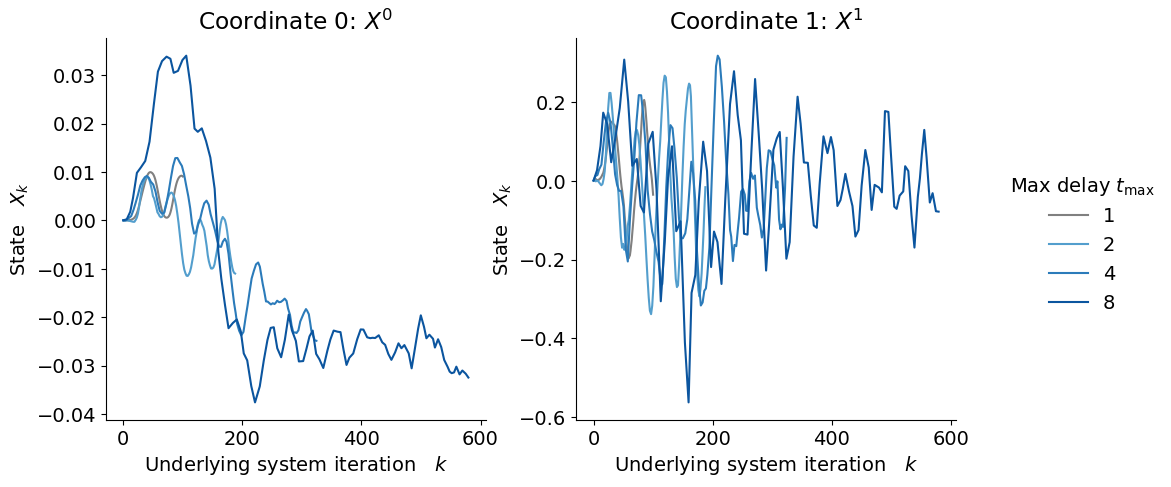

In [16]:
path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_barl_semimarkov_post_review/images"
folder_name = "exploration_trajectory"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

df_plot = (df_trajectory_data
      .set_index(["n_corresponding_dt", "seed"], append=True)
      .groupby(["action_delay_mode", "iteration"])
      .mean()
      .loc[:, pd.IndexSlice[["state", "iteration_exploration"], :]]
      .set_index("iteration_exploration", append=True)
      .stack()
      .reset_index())

# Plot the data w.r.t to the mode of the delay
g = sns.relplot(data=df_plot,
                x="iteration_exploration",
                y="state",
                hue="action_delay_mode",
                col="i",
                col_wrap=dim_x,
                kind="line",
                facet_kws=dict(sharey=False),
                legend="full",
                palette=list_color_palette
                )

g.set(xlabel="Underlying system iteration   $k$",
      ylabel="State   $X_k$")
g.legend.set_title("Max delay $t_{\\text{max}}$")
for i, ax in enumerate(g.axes):
    ax.set_title(f"Coordinate {i}: $X^{i}$")
    
g.savefig(f"{path_save_fig}/pendulum.png")